In [ ]:
!pip install transformers[torch]
!pip install -U datasets
!pip install sentencepiece
!pip install pynvml

In [ ]:
from datasets import list_datasets

datasets = list_datasets()

print(f"There are {len(datasets)} datasets available currently on huggingface.")
print(f"The first 10 are {datasets[:10]}")

<ipython-input-2-86eeae79ea7a>:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  datasets = list_datasets()
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


There are 103271 datasets available currently on huggingface.
The first 10 are ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [ ]:
from datasets import load_dataset

emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [ ]:
train_ds[10000]

{'text': 'i often feel dissatisfied with such discussions partly because of the persistent everyone is beautiful nonsense but partly because they rarely go past the effects of advertising on body image',
 'label': 3}

In [ ]:
train_ds.column_names

['text', 'label']

In [ ]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [ ]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [ ]:
def label_int2str(row, split):
    return emotions[split].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str, split="train")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Text(0.5, 1.0, 'Category Counts')

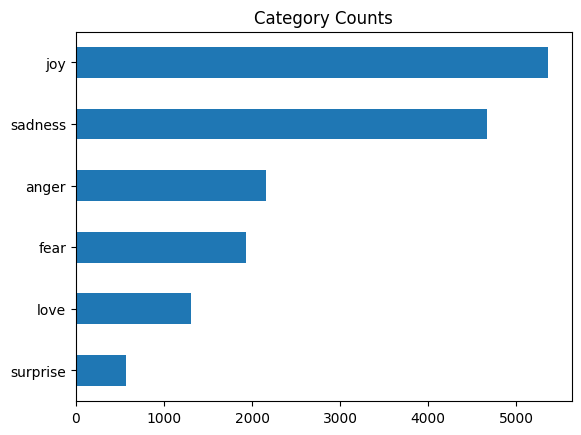

In [ ]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Category Counts")

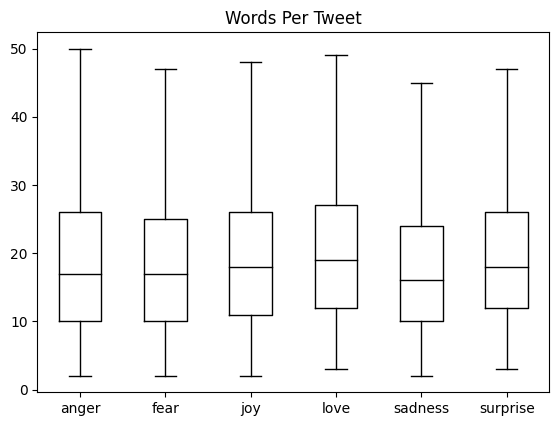

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("");


In [ ]:
from transformers import AutoTokenizer

model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
tokenizer.vocab_size

30522

In [ ]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [ ]:
tokenizer.model_max_length

512

In [ ]:
encoded_text = tokenizer.encode("This is Sparta!")
encoded_text

[101, 2023, 2003, 21251, 999, 102]

In [ ]:
for token in encoded_text:
    print(token, tokenizer.decode([token]))

101 [CLS]
2023 this
2003 is
21251 sparta
999 !
102 [SEP]


In [ ]:
from transformers import AutoModel
import torch

device = "cuda" if torch.cuda.is_available else "cpu"

model = AutoModel.from_pretrained(model_name).to(device)

In [ ]:
model.device

device(type='cuda', index=0)

In [ ]:
text = "This is warm-up test"
text_tensor = tokenizer.encode(text, return_tensors="pt").to(device)
text_tensor

tensor([[ 101, 2023, 2003, 4010, 1011, 2039, 3231,  102]], device='cuda:0')

In [ ]:
text_tensor.shape

torch.Size([1, 8])

In [ ]:
output = model(text_tensor)
output.last_hidden_state.shape

torch.Size([1, 8, 768])

In [ ]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=False)

In [ ]:
emotions.reset_format()
tokenize(emotions["train"][:3])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
emotions_encoded["train"].features

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
import numpy as np

def forward_pass(batch):
    input_ids = torch.tensor(batch["input_ids"]).to(device)
    attention_mask = torch.tensor(batch["attention_mask"]).to(device)

    with torch.no_grad():
        last_hidden_state = model(input_ids, attention_mask).last_hidden_state
        last_hidden_state = last_hidden_state.cpu().numpy()

    lhs_shape = last_hidden_state.shape
    boolean_mask = ~np.array(batch["attention_mask"]).astype(bool)
    boolean_mask = np.repeat(boolean_mask, lhs_shape[-1], axis=-1)
    boolean_mask = boolean_mask.reshape(lhs_shape)
    masked_mean = np.ma.array(last_hidden_state, mask=boolean_mask).mean(axis=1)
    batch["hidden_state"] = masked_mean.data
    return batch

emotions_encoded = emotions_encoded.map(forward_pass, batched=True, batch_size=16)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
emotions_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None),
 'hidden_state': Sequence(feature=Value(dtype='float64', id=None), length=-1, id=None)}

In [ ]:
import numpy as np

X_train = np.array(emotions_encoded["train"]["hidden_state"])
X_valid = np.array(emotions_encoded["validation"]["hidden_state"])
y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])

X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [ ]:
!pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3543 sha256=7dd87146508da3a38310f3b356d1fa301d557f7bb766d3eb333dc4a2f66674db
  Stored in directory: /root/.cache/pip/wheels/15/f1/28/53dcf7a309118ed35d810a5f9cb995217800f3f269ab5771cb
Successfully built umap


In [ ]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

### The Hidden State can be trained in dnn for the classification with label

## FineTuning the BERT

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_encoded["train"][0]

{'label': tensor(0),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    accuracy = accuracy_score(labels, preds)
    return {"f1_score": f1, "Accuracy": accuracy}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 32

logging_steps = len(emotions_encoded["train"]) // batch_size

training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    save_strategy="epoch"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"]
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1 Score,Accuracy
1,0.161600,0.159223,0.936983,0.936000
2,0.113400,0.141455,0.938679,0.938500


TrainOutput(global_step=1000, training_loss=0.13753327178955077, metrics={'train_runtime': 256.8623, 'train_samples_per_second': 124.58, 'train_steps_per_second': 3.893, 'total_flos': 720342861696000.0, 'train_loss': 0.13753327178955077, 'epoch': 2.0})

In [ ]:
results = trainer.evaluate()
results

{'eval_loss': 0.14145547151565552,
 'eval_f1_score': 0.938679226660217,
 'eval_Accuracy': 0.9385,
 'eval_runtime': 4.8861,
 'eval_samples_per_second': 409.321,
 'eval_steps_per_second': 12.894,
 'epoch': 2.0}

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.14145547151565552,
 'test_f1_score': 0.938679226660217,
 'test_Accuracy': 0.9385,
 'test_runtime': 4.1977,
 'test_samples_per_second': 476.454,
 'test_steps_per_second': 15.008}

In [ ]:
labels = emotions["train"].features["label"].names

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

y_preds = np.argmax(preds_output.predictions, axis=1)
confusion_matrix(y_preds, y_valid)

array([[534,   2,   3,   8,   6,   1],
       [  1, 669,  18,   2,   1,   3],
       [  0,  26, 157,   1,   0,   0],
       [  7,   0,   0, 260,   7,   0],
       [  8,   2,   0,   4, 188,   8],
       [  0,   5,   0,   0,  10,  69]])

In [ ]:
print(classification_report(y_valid, y_preds, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.96      0.97      0.97       550
         joy       0.96      0.95      0.96       704
        love       0.85      0.88      0.87       178
       anger       0.95      0.95      0.95       275
        fear       0.90      0.89      0.89       212
    surprise       0.82      0.85      0.84        81

    accuracy                           0.94      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.94      0.94      0.94      2000



In [ ]:
custom_tweet = "Oh, wow! I can't believe my eyes! This is absolutely incredible!"
input_tensor = tokenizer.encode(custom_tweet, return_tensors="pt").to("cuda")
logits = model(input_tensor).logits

In [ ]:
softmax = torch.nn.Softmax(dim=1)
probs = softmax(logits)[0]
probs = probs.cpu().detach().numpy()

In [ ]:
probs

array([0.00266946, 0.7303337 , 0.00303132, 0.00532742, 0.0069416 ,
       0.25169656], dtype=float32)

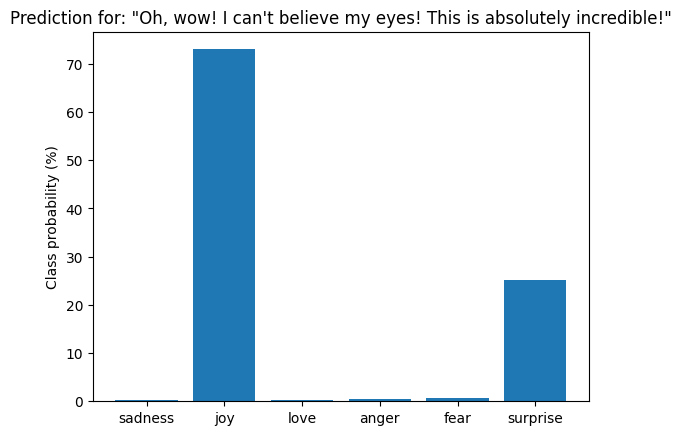

In [ ]:
plt.bar(labels, 100 * probs, color='C0')
plt.title(f'Prediction for: "{custom_tweet}"')
plt.ylabel("Class probability (%)");